This notebook contains the first experiments made to familiarize with the data and converting two spectra into a contingency table for adequation testing. There is also a program to plot a spectrum in the beginning and histograms later.

In [1]:
### Import necessary libraries

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as tk
import scipy.stats as st

In [2]:
### Fix directories

data_dir = "../data/initial database/output" #path to project folder

os.chdir(data_dir) #Select the project directory

In [3]:
### Import the data from the csv files

def select_directory(sample, file_name = "compounds", part = 1):
    """Returns the file directory corresponding to the file_name.csv file in the folder corresponding to the given sample
    (DiAcids, Fallopia, Ruthenium or Ruthenium2).
    
    the input part indicates the subfolder in which it is stored (pt1 or pt2)."""
    return data_dir + "/" + sample + "/pt" + str(part) + "/" + file_name + ".csv"

def df_from_csv(directory):
    """Extracts the csv file of the file contained in the directory and stores it in a pandas dataframe."""
    with open(directory) as file:
        return pd.read_csv(file)
    
def data_wir(sample):
    """Return a dataframe containing the data of ms2_spectra and an additional column "intratio" of
    the ratios ms2 peak intensity / sum of the intensities in the same ms2 spectrum.
    
    Note : wir means "with intratio" """
    
    print("Processing " + sample)
    
    #Read the csv files (there are two in this case, one in pt1 and one in pt2)
    df_compounds = df_from_csv(select_directory(sample))
    df_peaks = df_from_csv(select_directory(sample, file_name = "ms2_peaks"))
    
    #Adds the intensities of the peaks having the same spectrum_id.
    sums =  df_peaks.groupby("spectrum_id")["intensity"].sum()
    
    #Generate the intratio column.
    intratio = [df_peaks.intensity[i] / sums[df_peaks.spectrum_id[i]] for i in df_peaks.index]
    
    #Insert the intratio column into the dataframe
    df_peaks["intratio"] = intratio
    
    print("Completed conversion of " + sample)
    
    return df_peaks

#Convert the data into pandas dataframes and compute intratios.

sample_names = ["DiAcids", "Fallopia", "Ruthenium", "Ruthenium2"]

data = pd.DataFrame({"sample" : sample_names,
                     "compounds" : [df_from_csv(select_directory(sample)) for sample in sample_names],
                     "peaks" : [data_wir(sample) for sample in sample_names],
                     "spectra" : [df_from_csv(select_directory(sample, file_name = "ms2_spectra")) for sample in sample_names]
                    })
data.index = sample_names

Processing DiAcids
Completed conversion of DiAcids
Processing Fallopia
Completed conversion of Fallopia
Processing Ruthenium
Completed conversion of Ruthenium
Processing Ruthenium2
Completed conversion of Ruthenium2


In [4]:
def full_spectrum(sample):
    """Returns a dataframe indexed by spectrum_id with columns mz, intensity values and
    sum of intensities of the ms2 peaks corresponding to this spectrum id."""
    
    groups = data["peaks"][sample].groupby(["spectrum_id"])
    df = groups.agg(list)
    df["sum"] = groups.intensity.sum()
    
    return df.loc[:,["mz", "intensity", "sum"]]

full_sp = pd.Series([full_spectrum(sample) for sample in sample_names], index = sample_names)

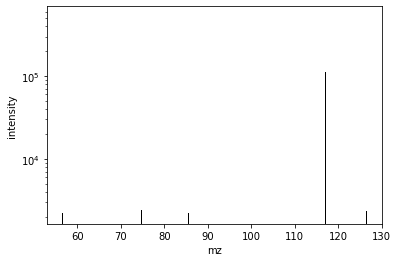

In [5]:
#How to plot a bar chart of the peaks.

df = full_sp["DiAcids"]
ind = df.index

plt.bar(df.mz[ind[1]], df.intensity[ind[1]], color = "#000000", width = .1)

plt.xlabel("mz")
plt.ylabel("intensity")
plt.yscale("log")

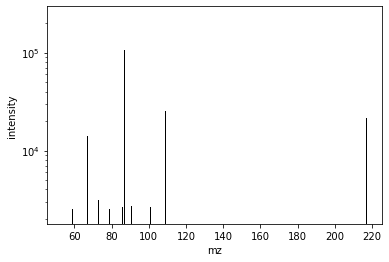

In [6]:
df = full_sp["Fallopia"]


plt.bar(df.mz["R04_02_0418"], df.intensity["R04_02_0418"], color = "#000000", width = .1)

plt.xlabel("mz")
plt.ylabel("intensity")
plt.yscale("log")

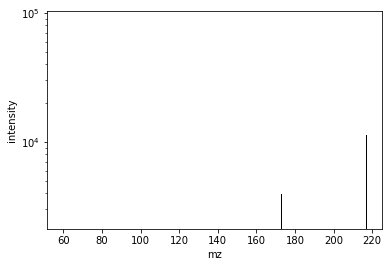

In [7]:
plt.bar(df.mz["R07_01_0426"], df.intensity["R07_01_0426"], color = "#000000", width = .1)

plt.xlabel("mz")
plt.ylabel("intensity")
plt.yscale("log")

In [ ]:
def get_spectrum(sample, spectrum_id):
    """Returns a pandas Series of the intensities associated to the given spectrum_id, indexed by
    mz."""
    return pd.Series(full_sp[sample].intensity[spectrum_id], index = full_sp[sample].mz[spectrum_id])

In [ ]:
#Computing a reasonable candidate for threshold below which two mz are considered different.
#I only had to run this cell once, I then stored the threshold in the variable threshold_mz.

for sample in sample_names:
    df = full_sp[sample]
    list_diff = []
    for list_mz in df.mz:
        for i in range(len(list_mz) - 1):
            list_diff.append(list_mz[i + 1] - list_mz[i])
    print(sample + " : " + str(min(list_diff)))

In [ ]:
#Computing a reasonable candidate for the minimal intensity that can be recorded in a ms2 peak.
#When comparing spectra, absence of a peak will be replaced by this value.


#threshold_int = min([min(data["peaks"][sample]["intensity"]) for sample in sample_names[1:]])
print("DiAcids : " + str(min(data["peaks"]["DiAcids"]["intensity"])))
print("Fallopia : " + str(min(data["peaks"]["Fallopia"]["intensity"])))
print("Ruthenium : " + str(min(data["peaks"]["Ruthenium"]["intensity"])))
print("Ruthenium2 : " + str(min(data["peaks"]["Ruthenium2"]["intensity"])))


In [ ]:
df = data["peaks"]["Ruthenium"]
print(len(df.loc[df["intensity"] < 250]))
print(len(df))

In [ ]:
for sample in sample_names:
    print(sample + " : " + str(max(data["peaks"][sample]["intensity"])))

In [ ]:
"""
The previous cells yield the following threshold values :
threshold_mz = 0.001

threshold_DF = 250 #Threshold for DiAcids or Fallopia

threshold_R = 2.5 #Threshold for Ruthenium
"""

def cont_table(samples, spectrum_ids, threshold_mz = .001, threshold_DF = 250, threshold_R = 2.5):
    """Given a couple of sample names and a couple of spectra id, returns the contingecy table of
    the two spectra. If a mz value appears in a spectrum but not in the other one, it is assigned
    the thresholding intensity value in the spectrum in which it doesn't appear."""
    
    #Set the thresholding values associated to the sample.
    if samples[0] in ["DiAcids", "Fallopia"]:
        th_0 = threshold_DF
    else:
        th_0 = threshold_R
    
    if samples[1] in ["DiAcids", "Fallopia"]:
        th_1 = threshold_DF
    else:
        th_1 = threshold_R
    
    #Get the data.
    spectrum_0 = get_spectrum(samples[0], spectrum_ids[0])
    spectrum_1 = get_spectrum(samples[1], spectrum_ids[1])
    
    #Those lists contain the mz values in increasing order and will be used as iterator.
    mz_0, mz_1 = list(spectrum_0.index)[:], list(spectrum_1.index)[:]
    
    #Initialization of the table that will be returned.
    table = [[], []]
    
    #Initialization of x and y.
    x, y = mz_0.pop(0), mz_1.pop(0)
    
    while mz_0 and mz_1: #The loop stops when one of the lists is empty.
        
        #The mz are the same so the intensities are added to the table in same position.
        if abs(x - y) < threshold_mz:
            table[0].append(spectrum_0[x])
            table[1].append(spectrum_1[y])
            x = mz_0.pop(0)
            y = mz_1.pop(0)
        
        #Since the mz are in increasing order, x < y means there is no peak at mz = x in
        #spectrum 1, so the intensity for this peak in spectrum 0 is added to the first
        #row of the table in same position as a thresholding value in the second row.
        elif x < y:
            table[0].append(spectrum_0[x])
            table[1].append(th_1)
            x = mz_0.pop(0)
        
        #The last case is y < x, which is the same as the previous block but the roles of
        #spectrum 0 and spectrum 1 are reversed.
        else:
            table[0].append(th_0)
            table[1].append(spectrum_1[y])
            y = mz_1.pop(0)
    
    #Complete the table if one of the mz lists is not empty at the end of the while loop.
    for x in mz_0:
        table[0].append(spectrum_0[x])
        table[1].append(th_1)
    for y in mz_1:
        table[0].append(th_0)
        table[1].append(spectrum_1[y])
        
    return np.array(table)


def cont_table_sharp(samples, spectrum_ids, threshold_mz = .001, threshold_DF = 250, threshold_R = 2.5):
    """Given a couple of sample names and a couple of spectra id, returns the contingecy table of
    the two spectra. If a mz value doesn't appear in one spectrum, it is ruled out of the contingency
    table."""
    
    #Set the thresholding values associated to the sample.
    if samples[0] in ["DiAcids", "Fallopia"]:
        th_0 = threshold_DF
    else:
        th_0 = threshold_R
    
    if samples[1] in ["DiAcids", "Fallopia"]:
        th_1 = threshold_DF
    else:
        th_1 = threshold_R
    
    #Get the data.
    spectrum_0 = get_spectrum(samples[0], spectrum_ids[0])
    spectrum_1 = get_spectrum(samples[1], spectrum_ids[1])
    
    #Those lists contain the mz values in increasing order and will be used as iterator.
    mz_0, mz_1 = list(spectrum_0.index)[:], list(spectrum_1.index)[:]
    
    #Initialization of the table that will be returned.
    table = [[], []]
    
    #Initialization of x and y.
    x, y = mz_0.pop(0), mz_1.pop(0)
    
    while mz_0 and mz_1: #The loop stops when one of the lists is empty.
        
        #The mz are the same so the intensities are added to the table in same position.
        if abs(x - y) < threshold_mz:
            table[0].append(spectrum_0[x])
            table[1].append(spectrum_1[y])
            x = mz_0.pop(0)
            y = mz_1.pop(0)
        
        elif x < y:
            x = mz_0.pop(0)
        
        #The last case is y < x, which is the same as the previous block but the roles of
        #spectrum 0 and spectrum 1 are reversed.
        else:
            y = mz_1.pop(0)
        
    return np.array(table)

In [ ]:
print(full_sp["DiAcids"].index[37])
print(full_sp["Fallopia"].index[5456])

In [ ]:
cont_table(["DiAcids", "Fallopia"], ["AcidMix100_3o0kV_01_1032", "R07_01_0426"])

In [ ]:
def ml_stat(table):
    """Given a contingency table, compute the statistic of the maximum likelihood
    for a test of independance between rows and columns, given by the formula
    T_ML = sum_{i, j} table_{i, j} log(table_[i, j] / m_{i, j})
    where m_{i, j} = (sum of row i) * (sum of column j) / (total sum of the table).
    
    hz is for handle zeroes."""
    
    #Number of rows and columns of the table.
    r, c = table.shape
    
    #Compute the sums of the columns.
    col_sums = np.sum(table, axis = 0)

    #Compute the sums of the rows and stores them as a column vector.
    row_sums = np.expand_dims(np.sum(table, axis = 1), 1)
    
    #Total sum.
    total = np.sum(row_sums)
    
    #Compute the m_{i, j}.
    m = np.multiply(row_sums, col_sums) / total
    
    #Returns the result using the formula. The absolute value is here to get a positive result, negative being
    #possible because of too poor machine precision when working with big numbers.
    return 2 * abs(np.sum(table * np.nan_to_num(np.log(table / m)))) / 5e3

def ml_stat_hz(table):
    """Given a contingency table, compute the statistic of the maximum likelihood
    for a test of independance between rows and columns, given by the formula
    T_ML = sum_{i, j} table_{i, j} log(table_[i, j] / m_{i, j})
    where m_{i, j} = (sum of row i) * (sum of column j) / (total sum of the table).
    
    hz is for handle zeroes."""
    
    #Number of rows and columns of the table.
    r, c = table.shape
    
    #Compute the sums of the columns.
    col_sums = np.sum(table, axis = 0)

    #Compute the sums of the rows and stores them as a column vector.
    row_sums = np.expand_dims(np.sum(table, axis = 1), 1)
    
    #Total sum.
    total = np.sum(row_sums)
    
    #Compute the m_{i, j}.
    m = np.multiply(row_sums, col_sums) / total
    
    #The expression might contain log(0), but it is always of the form 0 * log(0) so it can
    #be replaced by 0. Anyway, it shouldn't happen because thresholding values are provided
    #instead of zeros.
    with np.errstate(invalid = 'ignore',divide = 'ignore'):
        return 2 *  np.sum(table * np.nan_to_num(np.log(table / m)))

In [ ]:
ml_stat(cont_table(["DiAcids", "Fallopia"], ["AcidMix100_3o0kV_01_1032", "R07_01_0426"]))

As expected, the statistic is veery high since the two tables have nothing in common (their ms1 are not even the same).

In [ ]:
ml_stat(cont_table(["Fallopia", "Fallopia"], ["R07_01_0426", "R07_01_0426"]))

In [ ]:
cont_table(["Fallopia", "Fallopia"], ["R07_01_0426", "R07_01_0426"])

In [ ]:
get_spectrum("Fallopia", "R07_01_0426")

In [ ]:
x = np.linspace(0, 20, 1000)
y = st.chi2.cdf

plt.plot(x, st.chi2(2).pdf(x))
plt.plot(x, st.chi2(5).pdf(x), color = "black")
plt.plot(x, st.chi2(8).pdf(x), color = "red")
plt.show()

In [ ]:
def p_value_alt(samples, spectrum_ids):
    """Returns the p-value for an asymptotic likelihood test of independence for the contingency matrix computed from the
    two spectra corresponding to the input samples and spectrum ids."""
     #Compute the ML statistic.
    table = cont_table(samples, spectrum_ids)
    t = ml_stat(table)
    
    #The p-value is 1 - the cdf of the statistic for the d-1-dof chi^2 law where d is the number of columns of the table.
    return 1 - st.chi2(table.shape[1]).cdf(t)

def p_sharp(samples, spectrum_ids):
    """Returns the p-value for an asymptotic likelihood test of independence for the contingency matrix computed from the
    two spectra corresponding to the input samples and spectrum ids."""
     #Compute the ML statistic.
    table = cont_table_sharp(samples, spectrum_ids)
    t = ml_stat(table)
    
    #The p-value is 1 - the cdf of the statistic for the d-1-dof chi^2 law where d is the number of columns of the table.
    return 1 - st.chi2(table.shape[1]).cdf(t)


In [ ]:
p_value_alt(["Fallopia", "Fallopia"], ["R07_01_0426", "R07_01_0426"])

Accept the null hypothesis in this situation.

In [ ]:
p_value_alt(["DiAcids", "Fallopia"], ["AcidMix100_3o0kV_01_1032", "R07_01_0426"])

Here, reject the null hypothesis.

In [ ]:
#Returns True or False in function of the p-value for a test of level alpha.
def al_test(samples, spectrum_ids, alpha = .05):
    """Returns the result of an asymptotic likelihood test of level alpha for the table of contingency induced
    by the two input spectra."""
    return (p_value_alt(samples, spectrum_ids) < alpha )

In [ ]:
al_test(["Fallopia", "Fallopia"], ["R07_01_0426", "R07_01_0426"])

This was just to check the functions work properly. Now we want to first determine if two spectra can come from the same compound by comparing their MS1, then apply the likelihood ratio test. Let's take the Ruthenium sample for testing this time
because it contains less peaks than the others.

In [ ]:
sp_id = data["spectra"]["Ruthenium"]
df = full_sp["Ruthenium"]

sp_id.head(5)

In [ ]:
groups = sp_id.groupby(["compound_id"]).parent_mz.agg(list)

print(max([(max(x) - min(x)) for x in groups]))

In [ ]:
"""sp_id = data["spectra"]["Ruthenium"]
df = full_sp["Ruthenium"]

groups = sp_id.groupby(["compound_id"]).spectrum_id.agg(list)

storage = []

for comp_id in groups.index:
    id_list = groups[comp_id]
    var = []
    for i in range(len(id_list)):
        for j in range(i+1, len(id_list)):
            var.append(p_value_alt(["Ruthenium", "Ruthenium"], [id_list[i], id_list[j]]))
    storage.append([comp_id, var])""" #Commented because it takes a long time to run

In [ ]:
"""storage[5:10]""" #this is all zeros

In [ ]:
"""print(max([max(x[1] + [0]) for x in storage]))""" #yields 0.0

So : the likelihood test yield perfect adequation for all compounds of the Ruthenium data that have been identified as the same. (fishy : this is too perfect).

In [ ]:
"""sp_id = data["spectra"]["Fallopia"]
df = full_sp["Fallopia"]

groups = sp_id.groupby(["compound_id"]).spectrum_id.agg(list)

storage = []

for comp_id in groups.index:
    id_list = groups[comp_id]
    var = []
    for i in range(len(id_list)):
        for j in range(i+1, len(id_list)):
            var.append(p_value_alt(["Fallopia", "Fallopia"], [id_list[i], id_list[j]]))
    storage.append([comp_id, var])
    
print(max([max(x[1] + [0]) for x in storage]))"""
#Take minutes to run.

Conclusions that I draw from this experiment : Getting a large p-value for some samples in millions is to be expected, it doesn't indicate that the test is failing. It is even good to know that the test doesn't yield 0 in every case, it means the program probably does what it has been asked to do.

However, getting that much values close to 0 is not good : the test is wayy too conservative. I explain : with the testing methodology that has been put into place before, identification was certainly not achieved with a level of confidence that close to 1. The test gives a tremendously too large significance level, which is fishy. I think it comes from the fact that lower peaks are rendered irrelevant because the likelihood statistic weighs the peak significance proportionally to intensity. Thus, it is like performing the test only on the three largest peaks, which are most likely very close to one another because of the relation parameter/variance of Poisson laws.

In [ ]:
sp_id

In [ ]:
pd.set_option("display.max_rows", None)
#sp_id.loc[:, ["compound_id", "parent_mz"]].head(None)
sp_id.sort_values("parent_mz").loc[:, ["compound_id", "parent_mz"]].head(None)

In [ ]:
sp_id.loc[[sp_id["compound_id"][i] in ["Ruthenium_39", "Ruthenium_61"] for i in range(len(sp_id["compound_id"]))]]

In [ ]:
p_value_alt(["Ruthenium", "Ruthenium"], ["20161201_Kat-3_pos_01_1744", "20161201_Kat-3_pos_03_1863"])

In [ ]:
p_sharp(["Ruthenium", "Ruthenium"], ["20161201_Kat-3_pos_01_1744", "20161201_Kat-3_pos_03_1863"])

In [ ]:
p_sharp(["Ruthenium", "Ruthenium"], ["20161201_Kat-3_pos_01_1744", "20161201_Kat-3_pos_01_1757"])

In [ ]:
df = full_sp["Ruthenium"]
ind = df.index

plt.figure(figsize = (0.4 * 12, 0 . 4 * 22.5))

plt.subplot(311)
plt.bar(df.mz["20161201_Kat-3_pos_01_1744"], df.intensity["20161201_Kat-3_pos_01_1744"], color = "#000000", width = .1)
plt.bar(df.mz["20161201_Kat-3_pos_03_1863"], df.intensity["20161201_Kat-3_pos_03_1863"], color = "#FF9900", width = .1)

plt.xlabel("mz")
plt.ylabel("intensity")
plt.yscale("log")


plt.subplot(312)
plt.bar(df.mz["20161201_Kat-3_pos_01_1744"], df.intensity["20161201_Kat-3_pos_01_1744"], color = "#000000", width = .1)
plt.bar(df.mz["20161201_Kat-3_pos_01_1757"], df.intensity["20161201_Kat-3_pos_01_1757"], color = "#FF9900", width = .1)

plt.xlabel("mz")
plt.ylabel("intensity")
plt.yscale("log")

plt.subplot(313)
plt.bar(df.mz["20161201_Kat-3_pos_03_1863"], df.intensity["20161201_Kat-3_pos_03_1863"], color = "#000000", width = .1)
plt.bar(df.mz["20161201_Kat-3_pos_01_1757"], df.intensity["20161201_Kat-3_pos_01_1757"], color = "#FF9900", width = .1)

plt.xlabel("mz")
plt.ylabel("intensity")
plt.yscale("log")

plt.show()

In [ ]:
df = full_sp["Ruthenium"]
ind = df.index

plt.bar(df.mz["20161201_Kat-3_pos_01_1744"], df.intensity["20161201_Kat-3_pos_01_1744"], color = "#000000", width = .1)
plt.bar(df.mz["20161201_Kat-3_pos_01_1757"], df.intensity["20161201_Kat-3_pos_01_1757"], color = "#FF9900", width = .1)

plt.xlabel("mz")
plt.ylabel("intensity")
plt.yscale("log")

In [ ]:
def verysharp_table(samples, spectrum_ids, threshold_mz = .001, threshold_DF = 250, threshold_R = 2.5, cut_th = 5000):
    """Given a couple of sample names and a couple of spectra id, returns the contingecy table of
    the two spectra. If a mz value doesn't appear in one spectrum, it is ruled out of the contingency
    table."""
    
    #Set the thresholding values associated to the sample.
    if samples[0] in ["DiAcids", "Fallopia"]:
        th_0 = threshold_DF
    else:
        th_0 = threshold_R
    
    if samples[1] in ["DiAcids", "Fallopia"]:
        th_1 = threshold_DF
    else:
        th_1 = threshold_R
    
    #Get the data.
    spectrum_0 = get_spectrum(samples[0], spectrum_ids[0])
    spectrum_1 = get_spectrum(samples[1], spectrum_ids[1])
    
    #Those lists contain the mz values in increasing order and will be used as iterator.
    mz_0, mz_1 = list(spectrum_0.index)[:], list(spectrum_1.index)[:]
    
    #Initialization of the table that will be returned.
    table = [[], []]
    
    #Initialization of x and y.
    x, y = mz_0.pop(0), mz_1.pop(0)
    
    while mz_0 and mz_1: #The loop stops when one of the lists is empty.
        
        #The mz are the same so the intensities are added to the table in same position.
        if abs(x - y) < threshold_mz:
            if spectrum_0[x] > cut_th or spectrum_1[y] > cut_th:
                table[0].append(spectrum_0[x])
                table[1].append(spectrum_1[y])
                
            x = mz_0.pop(0)
            y = mz_1.pop(0)
        
        elif x < y:
            if spectrum_0[x] > cut_th:
                table[0].append(spectrum_0[x])
                table[1].append(th_1)
            x = mz_0.pop(0)
        
        else:
            if spectrum_1[y] > cut_th:
                table[0].append(th_0)
                table[1].append(spectrum_1[y])
            y = mz_1.pop(0)
        
    return np.array(table)

In [ ]:
verysharp_table(["DiAcids", "Fallopia"], ["AcidMix100_3o0kV_01_1032", "R07_01_0426"])

In [ ]:
verysharp_table(["Fallopia", "Fallopia"], ["R07_01_0426", "R07_01_0426"])

In [ ]:
verysharp_table(["Ruthenium", "Ruthenium"], ["20161201_Kat-3_pos_01_1744", "20161201_Kat-3_pos_01_1757"])

In [ ]:
def p_vsharp(samples, spectrum_ids):
    """Returns the p-value for an asymptotic likelihood test of independence for the contingency matrix computed from the
    two spectra corresponding to the input samples and spectrum ids."""
     #Compute the ML statistic.
    table = verysharp_table(samples, spectrum_ids)
    t = ml_stat(table)
    
    #The p-value is 1 - the cdf of the statistic for the d-1-dof chi^2 law where d is the number of columns of the table.
    return 1 - st.chi2(table.shape[1]).cdf(t)

In [ ]:
ml_stat(verysharp_table(["Ruthenium", "Ruthenium"], ["20161201_Kat-3_pos_01_1744", "20161201_Kat-3_pos_01_1757"]))

In [ ]:
p_vsharp(["Ruthenium", "Ruthenium"], ["20161201_Kat-3_pos_01_1744", "20161201_Kat-3_pos_01_1757"])